# Test set evaluation
We take our top model now and use it to generate final results

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
encoder_list = ["minilm", "deberta"] #["minilm"]
test_metrics = ["auprc", "ap"]

encoder_top_models = {'minilm': ('k25_r1_alpha0.050_tau1.00_lamnan.model', 0.7)} 
# old: k10_r2_alpha0.010_tau0.00_lamnan.model
baseline_top_models = \
        {'minilm': [('mlp', ">"), ("svd", "<")], \
        'deberta': [('deberta-prob', '>'), ('deberta-attn', '>'), ('deberta-entail', '>'), ('deberta-shap', '>')]}
    # {'minilm': [('mlp', ">"), ("svd", "<")]}

In [4]:
from evaluation import test_eval, extract_params, get_test_metrics
import utils
import pandas as pd

In [5]:
# encoder="minilm"
# base_df = []
# for model_thresh_pair in baseline_top_models["minilm"]:
#     best_model, best_thresh = model_thresh_pair
#     results_dict = utils.deserialize("/dfs/scratch1/gmachi/k2/K2/src/outputs/baselines/" + best_model +"-full.obj")
#     df = get_test_metrics(results_dict, encoder, best_model, best_thresh, test_metrics)
#     # add a "method" column to the df (K2, Attn, Prob)
#     df["method"] = best_model.split("_")[0]
#     base_df.append(df)
# base_df = pd.concat(base_df)

base_df = []
for encoder in ["minilm", "deberta"]:
    for model_thresh_pair in baseline_top_models[encoder]:
        best_model, best_thresh = model_thresh_pair
        results_dict = utils.deserialize("/dfs/scratch1/gmachi/k2/K2/src/outputs/baselines/" + best_model +"-full.obj")
        df = get_test_metrics(results_dict, encoder, best_model, best_thresh, test_metrics)
        # add a "method" column to the df (K2, Attn, Prob)
        df["method"] = best_model.split("_")[0]
        base_df.append(df)
base_df = pd.concat(base_df)


In [6]:
# base_df['encoder'] = df['encoder'].str.lower()


In [7]:
base_df

,encoder,model,threshold,datum_id,regime,metric,value,method
0,minilm,mlp,"(>, 0.005527460360181952)",doc_448_graph.obj,all,auprc,NaN,mlp
1,minilm,mlp,"(>, 0.005527460360181952)",doc_448_graph.obj,all,ap,NaN,mlp
2,minilm,mlp,"(>, 0.0014154207124087426)",doc_326_graph.obj,all,auprc,NaN,mlp
3,minilm,mlp,"(>, 0.0014154207124087426)",doc_326_graph.obj,all,ap,NaN,mlp
4,minilm,mlp,"(>, 0.47144088990613775)",doc_283_graph.obj,all,auprc,NaN,mlp
...,...,...,...,...,...,...,...,...
1417,deberta,deberta-shap,"(>, 0.19211497935590496)",doc_682_graph.obj,all,ap,NaN,deberta-shap
1418,deberta,deberta-shap,"(>, 0.1937643536766604)",doc_554_graph.obj,all,auprc,0.206544,deberta-shap
1419,deberta,deberta-shap,"(>, 0.1937643536766604)",doc_554_graph.obj,all,ap,0.216138,deberta-shap
1420,deberta,deberta-shap,"(>, 0.18821674512806708)",doc_264_graph.obj,all,auprc,NaN,deberta-shap


added speed test

In [8]:
speed_test=True

In [9]:
from time import process_time 
from time import perf_counter

In [10]:
test_df = []
all_cpus, all_walls = [], []
for encoder, (model_str, threshold) in encoder_top_models.items():
    encoder_alias = encoder.lower()
    cache_dir = "/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/" + encoder_alias + "_gridsearch/"
    results_cache_dir = cache_dir + encoder_alias + "-eval_results"
    model_cache_dir = cache_dir + encoder_alias + "-fitted_k2_models"
    processor_cache_dir = cache_dir + encoder_alias + "-fitted_k2_processors"
    linearized_cache_dir = cache_dir + encoder_alias + "-linearized_data"

    G_dir = "/dfs/scratch1/gmachi/datasets/wikisection_processed/test_Gs"  #+ encoder_alias
    gt_dir = "/dfs/scratch1/gmachi/datasets/wikisection_processed/test_gts" #+ encoder_alias
    label_dict = utils.deserialize("/dfs/scratch1/gmachi/datasets/wikisection_processed/test-doc-labs.obj")

    if speed_test == False:
        df = test_eval(model_str, threshold, test_metrics, model_cache_dir, processor_cache_dir, G_dir, gt_dir=gt_dir, label_dict=label_dict, modality="text", arm="test", speed_test=speed_test)
    else:
        t1_cpu = process_time()  
        t1_wall = perf_counter() 
        df, cpu, wall = test_eval(model_str, threshold, test_metrics, model_cache_dir, processor_cache_dir, G_dir, gt_dir=gt_dir, label_dict=label_dict, modality="text", arm="test", speed_test=speed_test)
        t2_cpu = process_time()  
        t2_wall  = perf_counter() 
        print(float(t2_cpu - t1_cpu)) 
        print(float(t2_wall - t1_wall))
        all_cpus.append(cpu)
        all_walls.append(wall)
        
    df['method'] = 'K2'
    test_df.append(df)
test_df = pd.concat(test_df)

dt cpu -> datum: 0.10098284199999963
dt wall -> datum: 0.13434287533164024
dt cpu -> datum: 0.09971529700000037
dt wall -> datum: 0.09971140325069427
dt cpu -> datum: 0.05304130300000054
dt wall -> datum: 0.051250554621219635
dt cpu -> datum: 0.16934438000000007
dt wall -> datum: 0.16845104098320007
dt cpu -> datum: 0.027475202999999837
dt wall -> datum: 0.027472946792840958
dt cpu -> datum: 0.2595569769999999
dt wall -> datum: 0.2589530274271965
dt cpu -> datum: 0.023986156000000314
dt wall -> datum: 0.02398541197180748
dt cpu -> datum: 0.15578902599999989
dt wall -> datum: 0.15526587888598442
dt cpu -> datum: 0.0020373810000000603
dt wall -> datum: 0.0020375996828079224
dt cpu -> datum: 0.16010916399999964
dt wall -> datum: 0.15961552038788795
dt cpu -> datum: 0.07778494399999936
dt wall -> datum: 0.07778283208608627
dt cpu -> datum: 0.06240627000000032
dt wall -> datum: 0.0624045766890049
dt cpu -> datum: 0.14890128199999975
dt wall -> datum: 0.14891202002763748
dt cpu -> datum: 0.0

In [11]:
combined_df = pd.concat([test_df, base_df])

mean_df = combined_df.groupby(['encoder', 'method','regime', 'metric'])['value'].mean().reset_index()
sem_df = combined_df.groupby(['encoder', 'method','regime', 'metric'])['value'].sem().reset_index()

mean_pvt = mean_df.pivot(index=['encoder', 'method', 'regime'], columns='metric', values='value')
mean_pvt = mean_pvt[test_metrics]

sem_pvt = sem_df.pivot(index=['encoder', 'method', 'regime'], columns='metric', values='value')
sem_pvt = sem_pvt[test_metrics]

#Save dfs
mean_pvt.to_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/all_test_results_mean-ALL-COMPLETE-NEW.csv')
sem_pvt.to_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/all_test_results_sem-ALL-COMPLETE-NEW.csv')
combined_df.to_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/all_test_results_points-ALL-COMPLETE-NEW.csv') # graph-level results
test_df.to_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/k2_test_results_points-ALL-COMPLETE-NEW.csv')  # k2 only


## speed test results

In [12]:
import numpy as np
encoders = ["minilm", "deberta"]

for i, cpu in enumerate(all_cpus):
    print(encoders[i], np.mean(cpu), np.std(cpu))

for i, wall in enumerate(all_walls):
    print(encoders[i], np.mean(wall), np.std(wall))

minilm 0.11218826141504186 0.11951057948013848
minilm 0.11199190847907724 0.11932928274382


For a full analysis on SHAP speed testing, see the `Doc-shap.ipynb` notebook

# Properties vs performance

In [13]:
from evaluation import compute_test_mrds, compute_test_rps, compute_test_mcs, compute_test_ccs

gts_path = "/dfs/scratch1/gmachi/datasets/wikisection_processed/test_gts"
rps_dict = compute_test_rps(gts_path, modality="text")
mrds_dict = compute_test_mrds(gts_path, modality="text")
ccs_dict = compute_test_ccs(gts_path, modality="text")
mcs_dict = compute_test_mcs(gts_path, modality="text")

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dfs/scratch1/gmachi/k2/K2/src/evaluation.py:593: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(size_cc) / len(size_cc) # prevalence / num CC


In [14]:
len(rps_dict.keys())

718

In [15]:
inter = set(rps_dict.keys()).intersection(set(test_df["datum_id"]))
len(inter)

712

In [17]:
# test_df
combined_df

,encoder,model,threshold,datum_id,regime,metric,value,method
0,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_700_graph.obj,all,auprc,NaN,K2
1,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_700_graph.obj,all,ap,NaN,K2
2,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_573_graph.obj,all,auprc,NaN,K2
3,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_573_graph.obj,all,ap,NaN,K2
4,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_488_graph.obj,all,auprc,NaN,K2
...,...,...,...,...,...,...,...,...
1417,deberta,deberta-shap,"(>, 0.19211497935590496)",doc_682_graph.obj,all,ap,NaN,deberta-shap
1418,deberta,deberta-shap,"(>, 0.1937643536766604)",doc_554_graph.obj,all,auprc,0.206544,deberta-shap
1419,deberta,deberta-shap,"(>, 0.1937643536766604)",doc_554_graph.obj,all,ap,0.216138,deberta-shap
1420,deberta,deberta-shap,"(>, 0.18821674512806708)",doc_264_graph.obj,all,auprc,NaN,deberta-shap


In [19]:
# test_df['rp'] = test_df['datum_id'].map(rps_dict)
# test_df['mrd'] = test_df['datum_id'].map(mrds_dict)
# test_df['ccs'] = test_df['datum_id'].map(ccs_dict)
# test_df['mcs'] = test_df['datum_id'].map(mcs_dict)
# test_df['srp'] = test_df['rp'] / test_df['ccs']

combined_df['rp'] = combined_df['datum_id'].map(rps_dict)
combined_df['mrd'] = combined_df['datum_id'].map(mrds_dict)
combined_df['ccs'] = combined_df['datum_id'].map(ccs_dict)
combined_df['mcs'] = combined_df['datum_id'].map(mcs_dict)
combined_df['srp'] = combined_df['rp'] / combined_df['ccs']

In [20]:
# test_df
combined_df

,encoder,model,threshold,datum_id,regime,metric,value,method,rp,mrd,ccs,mcs,srp
0,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_700_graph.obj,all,auprc,NaN,K2,0.000000,NaN,0,NaN,NaN
1,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_700_graph.obj,all,ap,NaN,K2,0.000000,NaN,0,NaN,NaN
2,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_573_graph.obj,all,auprc,NaN,K2,0.000000,NaN,0,NaN,NaN
3,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_573_graph.obj,all,ap,NaN,K2,0.000000,NaN,0,NaN,NaN
4,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_488_graph.obj,all,auprc,NaN,K2,0.000000,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,deberta,deberta-shap,"(>, 0.19211497935590496)",doc_682_graph.obj,all,ap,NaN,deberta-shap,0.000000,NaN,0,NaN,NaN
1418,deberta,deberta-shap,"(>, 0.1937643536766604)",doc_554_graph.obj,all,auprc,0.206544,deberta-shap,0.220238,0.027027,1,37.0,0.220238
1419,deberta,deberta-shap,"(>, 0.1937643536766604)",doc_554_graph.obj,all,ap,0.216138,deberta-shap,0.220238,0.027027,1,37.0,0.220238
1420,deberta,deberta-shap,"(>, 0.18821674512806708)",doc_264_graph.obj,all,auprc,NaN,deberta-shap,0.000000,NaN,0,NaN,NaN


In [22]:
# set(test_df["ccs"])
set(combined_df["ccs"])

{0, 1, 2}

In [23]:
# test_df.loc[test_df['encoder'].str.contains('minilm'), 'encoder'] = 'MiniLM'
combined_df.loc[combined_df['encoder'].str.contains('minilm'), 'encoder'] = 'MiniLM'

Choosing a top baseline (from bars below)

In [31]:
set(combined_df["method"])

{'K2',
 'deberta-attn',
 'deberta-entail',
 'deberta-prob',
 'deberta-shap',
 'mlp',
 'svd'}

In [40]:
combined_df.loc[combined_df['method'].str.contains('K2'), 'method'] = 'Prospector'
combined_df.loc[combined_df['method'].str.contains('mlp'), 'method'] = 'MLP'
combined_df.loc[combined_df['model'].str.contains('mlp'), 'model'] = 'MLP'
top_baseline = "MLP"

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils

def setup_figure(width=6, height=3):
    sns.set(style='white')
    sns.set_context('paper')
    plt.figure(figsize=(width,height))
    
pal = sns.color_palette('tab20')

In [43]:
met="auprc"
# filtered_df = test_df[test_df['metric'] == met]
filtered_df = combined_df[(combined_df['metric'] == met) & (combined_df['method'].isin(["Prospector", top_baseline]))]
filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]

In [46]:
filtered_df

,encoder,model,threshold,datum_id,regime,metric,value,method,rp,mrd,ccs,mcs,srp,pipeline
0,MiniLM,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_700_graph.obj,all,auprc,NaN,Prospector,0.0,NaN,0,NaN,NaN,MiniLM-Prospector
2,MiniLM,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_573_graph.obj,all,auprc,NaN,Prospector,0.0,NaN,0,NaN,NaN,MiniLM-Prospector
4,MiniLM,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_488_graph.obj,all,auprc,NaN,Prospector,0.0,NaN,0,NaN,NaN,MiniLM-Prospector
6,MiniLM,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_243_graph.obj,all,auprc,NaN,Prospector,0.0,NaN,0,NaN,NaN,MiniLM-Prospector
8,MiniLM,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_195_graph.obj,all,auprc,NaN,Prospector,0.0,NaN,0,NaN,NaN,MiniLM-Prospector
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,MiniLM,MLP,"(>, 0.03493742025220311)",doc_404_graph.obj,all,auprc,NaN,MLP,0.0,NaN,0,NaN,NaN,MiniLM-MLP
1416,MiniLM,MLP,"(>, 0.0040687763096878765)",doc_291_graph.obj,all,auprc,NaN,MLP,0.0,NaN,0,NaN,NaN,MiniLM-MLP
1418,MiniLM,MLP,"(>, 3.798162534450277e-06)",doc_334_graph.obj,all,auprc,NaN,MLP,0.0,NaN,0,NaN,NaN,MiniLM-MLP
1420,MiniLM,MLP,"(>, 0.015443916227858786)",doc_147_graph.obj,all,auprc,NaN,MLP,0.0,NaN,0,NaN,NaN,MiniLM-MLP


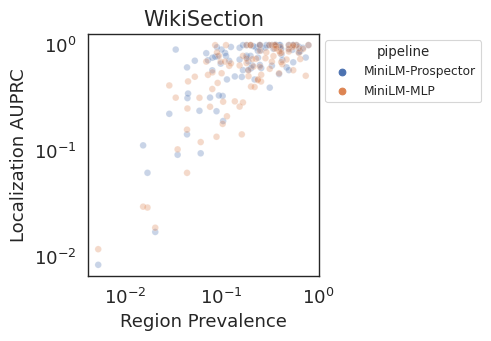

In [47]:
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.scatterplot(data=filtered_df, x="rp", y="value", hue="encoder", alpha=0.3)
g = sns.scatterplot(data=filtered_df, x="rp", y="value", hue="pipeline", alpha=0.3)
g.set_xscale("log")
g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("WikiSection", fontsize=15)

plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-rp_" + met + ".png", dpi=300, format='png')
plt.show()

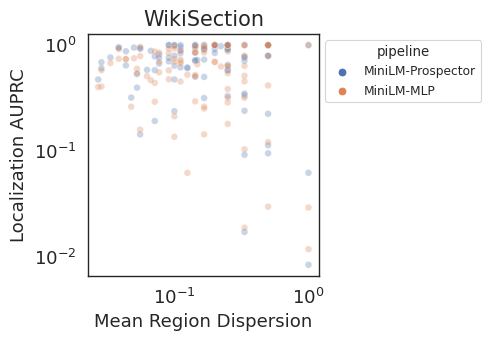

In [48]:
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.scatterplot(data=filtered_df, x="mrd", y="value", hue="encoder", alpha=0.3)
g = sns.scatterplot(data=filtered_df, x="mrd", y="value", hue="pipeline", alpha=0.3)
g.set_xscale("log")
g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("WikiSection", fontsize=15)

plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-mrd_" + met + ".png", dpi=300, format='png')
plt.show()

In [52]:
met="ap"
# filtered_df = test_df[test_df['metric'] == met]
filtered_df = combined_df[(combined_df['metric'] == met) & (combined_df['method'].isin(["Prospector", top_baseline]))]
filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]

/tmp/ipykernel_35715/884663924.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]


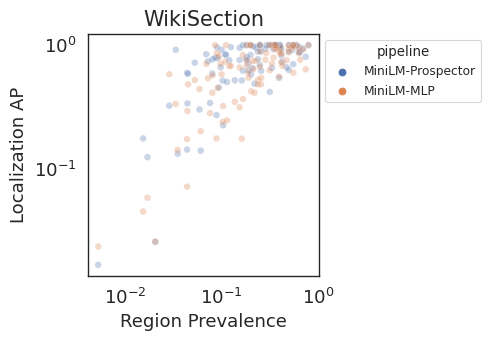

In [53]:
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.scatterplot(data=filtered_df, x="rp", y="value", hue="encoder", alpha=0.3)
g = sns.scatterplot(data=filtered_df, x="rp", y="value", hue="pipeline", alpha=0.3)

g.set_xscale("log")
g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AP', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("WikiSection", fontsize=15)

plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-rp_" + met + ".png", dpi=300, format='png')
plt.show()

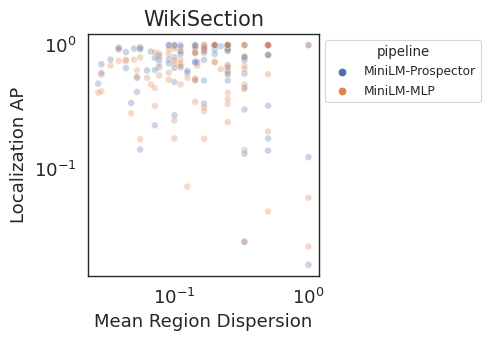

In [54]:
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.scatterplot(data=filtered_df, x="mrd", y="value", hue="encoder", alpha=0.3)
g = sns.scatterplot(data=filtered_df, x="mrd", y="value", hue="pipeline", alpha=0.3)

g.set_xscale("log")
g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Localization AP', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("WikiSection", fontsize=15)

plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-mrd_" + met + ".png", dpi=300, format='png')
plt.show()

# Trying rolling average

In [55]:
import numpy as np
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'full')

Filter data

In [56]:
# filtered_df = test_df[test_df['rp'].notnull()]
# filtered_df = filtered_df[filtered_df['mrd'].notnull()]
met="auprc"
# filtered_df = test_df[test_df['metric'] == met]
filtered_df = combined_df[(combined_df['metric'] == met) & (combined_df['method'].isin(["Prospector", top_baseline]))]
filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]

/tmp/ipykernel_35715/3177979318.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]


/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


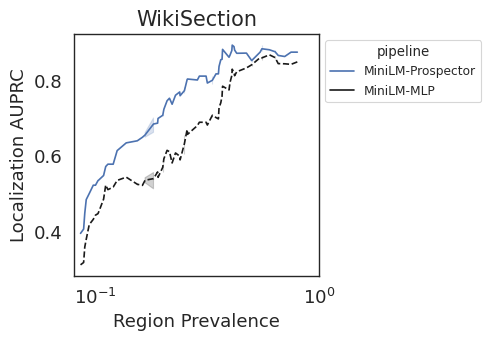

In [62]:
# used to be test_df below
# running_means = filtered_df.sort_values('rp').groupby('encoder').apply(lambda x: movingaverage(x['value'], 20))
# mean_data = []
# for enc, df in filtered_df.sort_values('rp').groupby('encoder'):
#     mean_data.extend(list(zip(df['rp'], running_means[enc], [enc]*len(df))))
# mean_data = pd.DataFrame(mean_data, columns=['rp', 'value', 'encoder'])


running_means = filtered_df.sort_values('rp').groupby('pipeline').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in filtered_df.sort_values('rp').groupby('pipeline'):
    mean_data.extend(list(zip(df['rp'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['rp', 'value', 'pipeline'])

# met = test_metrics[0]
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.lineplot(data=mean_data.reset_index(), x='rp', y='value', hue='encoder', hue_order=['MiniLM'])
g = sns.lineplot(data=mean_data.reset_index(), x='rp', y='value', hue='pipeline', hue_order=['MiniLM-Prospector', 'MiniLM-MLP'], palette=['b', 'k'])
g.lines[1].set_linestyle("--")

g.set_xscale("log")
g.set_xlim(8e-2, 1e0) # added for clarity
 
# g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("WikiSection", fontsize=15)
plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-rp_" + met + "_LINE.png", dpi=300, format='png')
plt.show()

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


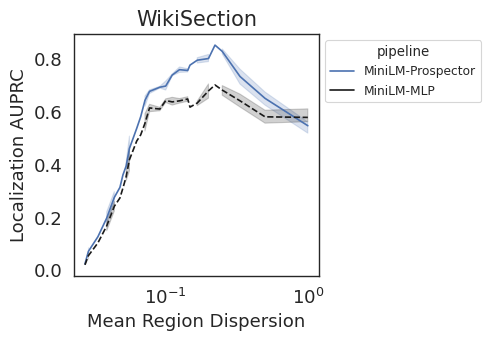

In [66]:
# used to be test_df below
# running_means = filtered_df.sort_values('mrd').groupby('encoder').apply(lambda x: movingaverage(x['value'], 20))
# # print(running_means)
# mean_data = []
# for enc, df in filtered_df.sort_values('mrd').groupby('encoder'):
#     mean_data.extend(list(zip(df['mrd'], running_means[enc], [enc]*len(df))))
# mean_data = pd.DataFrame(mean_data, columns=['mrd', 'value', 'encoder'])

running_means = filtered_df.sort_values('mrd').groupby('pipeline').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in filtered_df.sort_values('mrd').groupby('pipeline'):
    mean_data.extend(list(zip(df['mrd'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['mrd', 'value', 'pipeline'])


# met = test_metrics[0]
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.lineplot(data=mean_data.reset_index(), x='mrd', y='value', hue='encoder', hue_order=['MiniLM'])
g = sns.lineplot(data=mean_data.reset_index(), x='mrd', y='value', hue='pipeline', hue_order=['MiniLM-Prospector', 'MiniLM-MLP'], palette=['b', 'k'])
g.lines[1].set_linestyle("--")


g.set_xscale("log")
# g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("WikiSection", fontsize=15)
plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-mrd_" + met + "_LINE.png", dpi=300, format='png')
plt.show()

In [70]:
met="ap"
# filtered_df = test_df[test_df['metric'] == met]
filtered_df = combined_df[(combined_df['metric'] == met) & (combined_df['method'].isin(["Prospector", top_baseline]))]
filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]

/tmp/ipykernel_35715/884663924.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]


/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


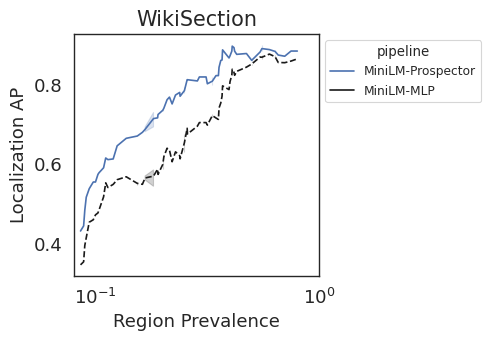

In [71]:
# used to be test_df below
# running_means = filtered_df.sort_values('rp').groupby('encoder').apply(lambda x: movingaverage(x['value'], 20))
# mean_data = []
# for enc, df in filtered_df.sort_values('rp').groupby('encoder'):
#     mean_data.extend(list(zip(df['rp'], running_means[enc], [enc]*len(df))))
# mean_data = pd.DataFrame(mean_data, columns=['rp', 'value', 'encoder'])

running_means = filtered_df.sort_values('rp').groupby('pipeline').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in filtered_df.sort_values('rp').groupby('pipeline'):
    mean_data.extend(list(zip(df['rp'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['rp', 'value', 'pipeline'])


# met = test_metrics[0]
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.lineplot(data=mean_data.reset_index(), x='rp', y='value', hue='encoder', hue_order=['MiniLM'])
g = sns.lineplot(data=mean_data.reset_index(), x='rp', y='value', hue='pipeline', hue_order=['MiniLM-Prospector', 'MiniLM-MLP'], palette=['b', 'k'])
g.lines[1].set_linestyle("--")

g.set_xscale("log")
g.set_xlim(8e-2, 1e0) # added for clarity
 
# g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AP', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("WikiSection", fontsize=15)
plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-rp_" + met + "_LINE.png", dpi=300, format='png')
plt.show()

In [99]:
for df in filtered_df.groupby("pipeline"):
    print(df[0])
    print("Mean:", df[1]["value"].mean())
    print("Std:", df[1]["value"].std())
    print("Delta:", df[1]["value"].max() - df[1]["value"].min())
    print()

MiniLM-MLP
Mean: 0.6478812096822952
Std: 0.28788075139296665
Delta: 0.9761904761904762

MiniLM-Prospector
Mean: 0.729537702379642
Std: 0.27186915986966004
Delta: 0.9830508474576274



/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


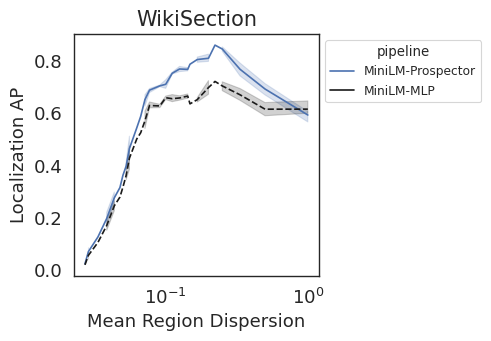

In [69]:
# used to be test_df below
# running_means = filtered_df.sort_values('mrd').groupby('encoder').apply(lambda x: movingaverage(x['value'], 20))
# mean_data = []
# for enc, df in filtered_df.sort_values('mrd').groupby('encoder'):
#     mean_data.extend(list(zip(df['mrd'], running_means[enc], [enc]*len(df))))
# mean_data = pd.DataFrame(mean_data, columns=['mrd', 'value', 'encoder'])

running_means = filtered_df.sort_values('mrd').groupby('pipeline').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in filtered_df.sort_values('mrd').groupby('pipeline'):
    mean_data.extend(list(zip(df['mrd'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['mrd', 'value', 'pipeline'])

# met = test_metrics[0]
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.lineplot(data=mean_data.reset_index(), x='mrd', y='value', hue='encoder', hue_order=['MiniLM'])
g = sns.lineplot(data=mean_data.reset_index(), x='mrd', y='value', hue='pipeline', hue_order=['MiniLM-Prospector', 'MiniLM-MLP'], palette=['b', 'k'])
g.lines[1].set_linestyle("--")

g.set_xscale("log")
# g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Localization AP', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("WikiSection", fontsize=15)
plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-mrd_" + met + "_LINE.png", dpi=300, format='png')
plt.show()

# Plotting test set results

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils


# combined_df = pd.read_csv("/home/k2/K2/src/outputs/k2-test/all_test_results_points.csv")
# combined_df = pd.read_csv("/dfs/scratch1/gmachi/gcp_backup/k2/k2-test/all_test_results_points.csv")
# combined_df = pd.read_csv("/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/all_test_results_points-ALL-COMPLETE.csv")
combined_df = pd.read_csv("/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/all_test_results_points-ALL-COMPLETE-NEW.csv")


In [140]:
combined_df[combined_df.metric == "auprc"].reset_index()

,index,Unnamed: 0,encoder,model,threshold,datum_id,regime,metric,value,method
0,0,0,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_700_graph.obj,all,auprc,NaN,K2
1,2,2,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_573_graph.obj,all,auprc,NaN,K2
2,4,4,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_488_graph.obj,all,auprc,NaN,K2
3,6,6,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_243_graph.obj,all,auprc,NaN,K2
4,8,8,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_195_graph.obj,all,auprc,NaN,K2
...,...,...,...,...,...,...,...,...,...,...
4978,9956,1412,deberta,deberta-shap,"('>', 0.20749473746677505)",doc_619_graph.obj,all,auprc,NaN,deberta-shap
4979,9958,1414,deberta,deberta-shap,"('>', 0.19034090948954335)",doc_177_graph.obj,all,auprc,NaN,deberta-shap
4980,9960,1416,deberta,deberta-shap,"('>', 0.19211497935590496)",doc_682_graph.obj,all,auprc,NaN,deberta-shap
4981,9962,1418,deberta,deberta-shap,"('>', 0.1937643536766604)",doc_554_graph.obj,all,auprc,0.206544,deberta-shap


In [141]:
combined_df.loc[combined_df["encoder"] == "minilm"]

,Unnamed: 0,encoder,model,threshold,datum_id,regime,metric,value,method
0,0,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_700_graph.obj,all,auprc,NaN,K2
1,1,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_700_graph.obj,all,ap,NaN,K2
2,2,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_573_graph.obj,all,auprc,NaN,K2
3,3,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_573_graph.obj,all,ap,NaN,K2
4,4,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_488_graph.obj,all,auprc,NaN,K2
...,...,...,...,...,...,...,...,...,...
4267,1419,minilm,svd,"('<', 4786.109077709282)",doc_220_graph.obj,all,ap,NaN,svd
4268,1420,minilm,svd,"('<', 4786.083964693566)",doc_698_graph.obj,all,auprc,0.091436,svd
4269,1421,minilm,svd,"('<', 4786.083964693566)",doc_698_graph.obj,all,ap,0.105388,svd
4270,1422,minilm,svd,"('<', 4785.853329817015)",doc_83_graph.obj,all,auprc,NaN,svd


In [142]:
# rename methods, model
combined_df.loc[combined_df['model'].str.contains('svd'), 'model'] = 'SVM'
combined_df.loc[combined_df['model'].str.contains('mlp'), 'model'] = 'MLP'

combined_df.loc[combined_df['method'].str.contains('svd'), 'method'] = 'SVM'
combined_df.loc[combined_df['method'].str.contains('mlp'), 'method'] = 'MLP'
combined_df.loc[combined_df['method'].str.contains('K2'), 'method'] = 'Prospector'

combined_df.loc[combined_df['method'].str.contains('attn'), 'method'] = 'Attention'
combined_df.loc[combined_df['method'].str.contains('entail'), 'method'] = 'Entailment'
combined_df.loc[combined_df['method'].str.contains('prob'), 'method'] = 'Probability'
combined_df.loc[combined_df['method'].str.contains('shap'), 'method'] = 'SHAP'

combined_df.loc[combined_df['encoder'].str.contains('minilm'), 'encoder'] = 'MiniLM'
combined_df.loc[combined_df['encoder'].str.contains('deberta'), 'encoder'] = 'DeBERTa'

In [144]:
test_metrics = ["auprc"]

/tmp/ipykernel_128057/4069585755.py:13: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


nan
0.2165770750458402
nan
0.47646032157657475
nan
0.5844835319345549
nan
0.2920331794381818
0.2839737574483241
nan
0.6261066802283892
nan
0.7107424450165768
nan


<Figure size 640x480 with 0 Axes>

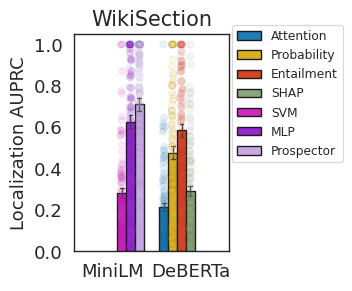

In [163]:
for met in test_metrics:
    subdf = combined_df[combined_df.metric == met].reset_index()
    plt.clf()
    # p=sns.color_palette("Set1")
    # colors at: https://xkcd.com/color/rgb/
    p = sns.xkcd_palette(["cerulean","goldenrod","vermillion","sage", "fuchsia","violet","lavender","mahogany","celadon"])
    # p = sns.xkcd_palette(["white"])
    # hs = ['--', '+', 'x', '\\', "/", "|", "o", ".", "-", '--', '+', 'x', '\\', "/", "|", "o", ".", "-"]
    if met == 'auprc':
        setup_figure(6,3) #(3,3)
        hue_order = ["Attention", "Probability", "Entailment", "SHAP", 'SVM', 'MLP', "Prospector"]
        ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
        plt.title("WikiSection", fontsize=15)
        ax.set_ylabel('Localization AUPRC', fontsize=13)
        ax.set_xlabel('')
        ax.tick_params(labelsize=13)
        # Loop over the bars
        # for i,thisbar in enumerate(ax.patches):
        #     # Set a different hatch for each bar
        #     thisbar.set_hatch(hs[i])

        for p in ax.patches:
            y = p.get_height()
            print(y)

        plt.legend(loc="upper right", bbox_to_anchor=(1.77, 1.07)) # (loc='upper left') #  labels=['SVM', 'MLP', "Prospector"]
        
        # plt.legend(loc=(0.65,1.01))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3), sharey=True, gridspec_kw={'wspace': 0})
        sns.barplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax2, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="w")
        sns.stripplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax2, legend=False)
        # ax1.yaxis.set_label_position('left')

        ax2.set_title('  '+'class-1', loc='left')
        ax2.set_ylabel('')
        ax2.set_yticklabels([])
        ax2.legend_.remove()
    
        sns.barplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax1, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax1, legend=False)
        ax1.legend_.remove()
    
        # optionally use the same scale left and right
        xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
        ax1.set_xlim(xmax=xmax)
        ax2.set_xlim(xmax=xmax)

        ax1.invert_xaxis()  # reverse the direction
        ax1.tick_params(axis='y', labelleft=True, left=True, labelright=False, right=False)
        ax1.set_ylabel('')
        ax1.set_title('all data'+'  ', loc='right')

        plt.legend(loc=(-1.01,1.02))
        fig.suptitle(met, fontsize=15)
    
    plt.tight_layout()
    # plt.savefig("/home/k2/K2/src/outputs/k2-test/k2-vs-baseline_" + met + ".png", dpi=2000, format='png')
    plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-vs-baseline_" + met + ".png", dpi=300, format='png')
    plt.show()

In [164]:
subdf[subdf.regime == 'all'].groupby(['encoder','method'])['value'].describe()[['mean','std']]

mean       std
encoder method                         
DeBERTa Attention    0.216577  0.190892
        Entailment   0.584484  0.283256
        Probability  0.476460  0.304743
        SHAP         0.292033  0.247737
MiniLM  MLP          0.626107  0.300554
        Prospector   0.710742  0.289105
        SVM          0.283974  0.233359

In [165]:
subdf[subdf.regime == 'all'].groupby(['encoder','method'])['value'].sem()

encoder  method     
DeBERTa  Attention      0.019902
         Entailment     0.029532
         Probability    0.031772
         SHAP           0.025828
MiniLM   MLP            0.031335
         Prospector     0.030141
         SVM            0.024329
Name: value, dtype: float64

In [166]:
test_metrics = ["ap"]

/tmp/ipykernel_128057/2864606687.py:13: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


nan
0.2435934204402705
nan
0.5022579438149917
nan
0.6172996395370761
nan
0.32163599635230594
0.3165084144358862
nan
0.6478812096822952
nan
0.729537702379642
nan


<Figure size 640x480 with 0 Axes>

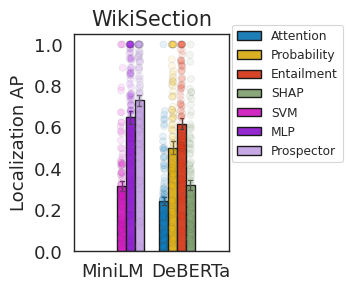

In [167]:
for met in test_metrics:
    subdf = combined_df[combined_df.metric == met].reset_index()
    plt.clf()
    # p=sns.color_palette("Set1")
    # colors at: https://xkcd.com/color/rgb/
    p = sns.xkcd_palette(["cerulean","goldenrod","vermillion","sage", "fuchsia","violet","lavender","mahogany","celadon"])
    # p = sns.xkcd_palette(["white"])
    # hs = ['--', '+', 'x', '\\', "/", "|", "o", ".", "-", '--', '+', 'x', '\\', "/", "|", "o", ".", "-"]
    if met == 'ap':
        setup_figure(6,3) #(3,3)
        hue_order = ["Attention", "Probability", "Entailment", "SHAP", 'SVM', 'MLP', "Prospector"]
        ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
        plt.title("WikiSection", fontsize=15)
        ax.set_ylabel('Localization AP', fontsize=13)
        ax.set_xlabel('')
        ax.tick_params(labelsize=13)
        # Loop over the bars
        # for i,thisbar in enumerate(ax.patches):
        #     # Set a different hatch for each bar
        #     thisbar.set_hatch(hs[i])

        for p in ax.patches:
            y = p.get_height()
            print(y)

        plt.legend(loc="upper right", bbox_to_anchor=(1.77, 1.07)) # (loc='upper left') #  labels=['SVM', 'MLP', "Prospector"]
        
        # plt.legend(loc=(0.65,1.01))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3), sharey=True, gridspec_kw={'wspace': 0})
        sns.barplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax2, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="w")
        sns.stripplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax2, legend=False)
        # ax1.yaxis.set_label_position('left')

        ax2.set_title('  '+'class-1', loc='left')
        ax2.set_ylabel('')
        ax2.set_yticklabels([])
        ax2.legend_.remove()
    
        sns.barplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax1, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax1, legend=False)
        ax1.legend_.remove()
    
        # optionally use the same scale left and right
        xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
        ax1.set_xlim(xmax=xmax)
        ax2.set_xlim(xmax=xmax)

        ax1.invert_xaxis()  # reverse the direction
        ax1.tick_params(axis='y', labelleft=True, left=True, labelright=False, right=False)
        ax1.set_ylabel('')
        ax1.set_title('all data'+'  ', loc='right')

        plt.legend(loc=(-1.01,1.02))
        fig.suptitle(met, fontsize=15)
    
    plt.tight_layout()
    # plt.savefig("/home/k2/K2/src/outputs/k2-test/k2-vs-baseline_" + met + ".png", dpi=2000, format='png')
    plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-vs-baseline_" + met + ".png", dpi=300, format='png')
    plt.show()

In [168]:
subdf[subdf.regime == 'all'].groupby(['encoder','method'])['value'].describe()[['mean','std']]

mean       std
encoder method                         
DeBERTa Attention    0.243593  0.196985
        Entailment   0.617300  0.265083
        Probability  0.502258  0.295165
        SHAP         0.321636  0.249762
MiniLM  MLP          0.647881  0.287881
        Prospector   0.729538  0.271869
        SVM          0.316508  0.232894

In [169]:
subdf[subdf.regime == 'all'].groupby(['encoder','method'])['value'].sem()

encoder  method     
DeBERTa  Attention      0.020537
         Entailment     0.027637
         Probability    0.030773
         SHAP           0.026040
MiniLM   MLP            0.030014
         Prospector     0.028344
         SVM            0.024281
Name: value, dtype: float64